**Exploratory Data Analysis of the final Plants of the World Online and Wikipedia datasets.**

- For the species' descriptions, we analyze the distribution of word count and analyze the most common words of the corpus.
- For the species' traits, we analyze the trait coverage, as well as within trait class distribution.

# Libraries & Functions

In [1]:
'''Math & Data Libraries'''
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.ops import unary_union

In [2]:
'''Visualization Libraries'''
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import cmasher as cmr

cmap = cmr.amber
sns.set_style("whitegrid", {"grid.color": "0.5", "axes.edgecolor": "0.2"})
color_palette = [ "#007597", "#FF8853", "#C1C36D", "#FFE174","#00A697", "#BC97E0", "#ffc0bf"]
sns.set_palette(sns.color_palette(color_palette))

In [3]:
'''NLP Libraries'''
import nltk
from nltk import ngrams, FreqDist
from wordcloud import WordCloud, ImageColorGenerator

In [4]:
''' Miscellaneous Libraries'''
from tqdm import tqdm
import pyreadr

In [94]:
def combine_description_geo_data(df, geo_GIFT):
    """
    Combine the POWO/WIKI and geo_GIFT databases regards to their species name and add geographic data to the descriptions
    """
    geo_GIFT["key"] = geo_GIFT["species"]
    df["key"] = df["name"]
    df = pd.merge(df, geo_GIFT[["list_ID", "key"]], how = "left", on = "key")
    df.drop("key", axis=1, inplace=True)
    return df

"""Combine the POWO and Geometry databases regards to their species name"""
def combine_description_geometry(df, POWO_world):
    """
    Combine the POWO/WIKI and POWO_world databases regards to their geographic entity ID name and add geometries
    """
    POWO_world["key"] = POWO_world["IDforGIFT"]
    df["key"] = df["list_ID"]
    df = pd.merge(df, POWO_world, how = "left", on = "key")
    df.drop("key", axis=1, inplace=True)
    return df

# Input Data

## Plants of the World Online - POWO GIFT

In [5]:
df_POWO_GIFT = pd.read_excel("../Data//Final Databases//POWO_GIFT.xlsx")

## Wikipedia - WIKI GIFT

In [6]:
df_WIKI_GIFT = pd.read_excel("../Data//Final Databases//WIKI_GIFT.xlsx")

## Statistics

In [29]:
for df_name, df in zip(["POWO", "WIKI"], [df_POWO_GIFT, df_WIKI_GIFT]): 
    print("Dataset {}".format(df_name))
    print("\tAverage number of description categories per species: {} ({})".format(np.mean(df[f"{df_name}_id_N"]), np.std(df[f"{df_name}_id_N"])))

Dataset POWO
	Average number of description categories per species: 4.864600767527176 (5.8381097115934155)
Dataset WIKI
	Average number of description categories per species: 3.50410742212076 (3.0993821042413146)


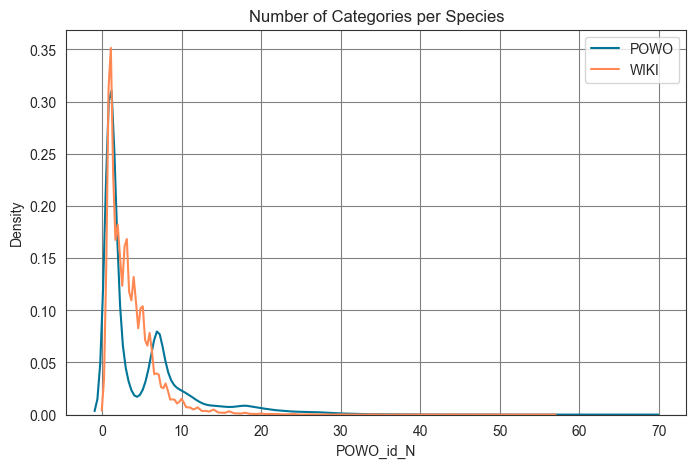

In [20]:
plt.subplots(figsize = (8,5), ncols=1, nrows=1)
plt.title("Number of Categories per Species")
for df_name, df in zip(["POWO", "WIKI"], [df_POWO_GIFT, df_WIKI_GIFT]): 
    sns.kdeplot(df[f"{df_name}_id_N"], label = df_name)
plt.legend()
plt.show()

# Description Word Count & Character Count Analysis 

## Description Character Count

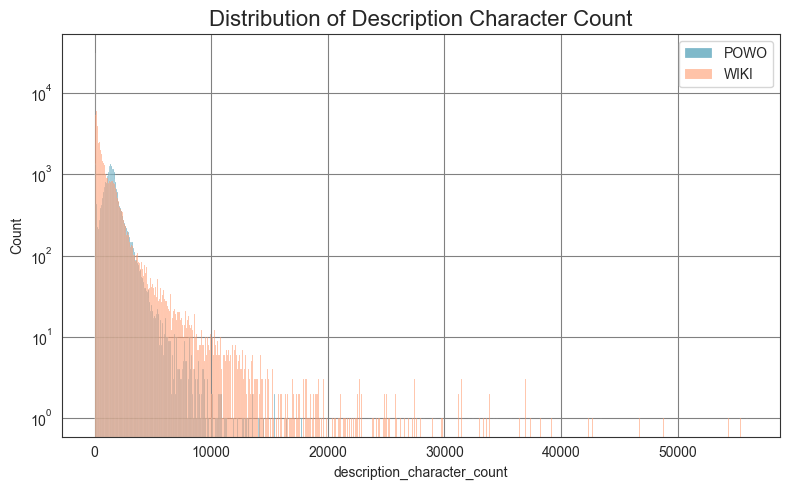

In [25]:
fig, ax = plt.subplots(figsize=(8,5), nrows = 1)
plt.title("Distribution of Description Character Count", fontsize=16)

for df_name, df in zip(["POWO", "WIKI"], [df_POWO_GIFT, df_WIKI_GIFT]): 
    sns.histplot(df["description_character_count"], alpha = 0.5, label = df_name)

# plt.xscale('log')
plt.yscale("log")
plt.legend()
plt.tight_layout()
plt.show()

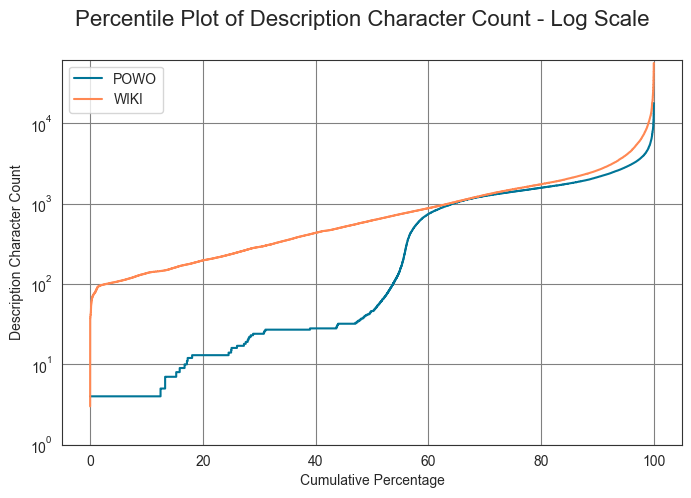

In [28]:
fig, ax = plt.subplots(figsize=(8,5), nrows = 1)
plt.suptitle("Percentile Plot of Description Character Count - Log Scale", fontsize=16)
for df_name, df in zip(["POWO", "WIKI"], [df_POWO_GIFT, df_WIKI_GIFT]): 
    sorted_data = np.sort(df["description_character_count"]) 
    plt.step(100*np.arange(sorted_data.size)/sorted_data.size, sorted_data, label = df_name)

plt.xlabel("Cumulative Percentage")
plt.ylabel("Description Character Count")
plt.yscale("log")
plt.ylim(1, np.max(sorted_data)*1.1)
plt.legend()
plt.show()

## Description Word Count

In [31]:
for df_name, df in zip(["POWO", "WIKI"], [df_POWO_GIFT, df_WIKI_GIFT]): 
    print("Dataset {}".format(df_name))
    print("Number of descriptions with less than 5 words: {}".format(np.round(np.sum(df["description_word_count"]<5)/len(df["description_word_count"]), 2)))

Dataset POWO
Number of descriptions with less than 5 words: 0.47
Dataset WIKI
Number of descriptions with less than 5 words: 0.0


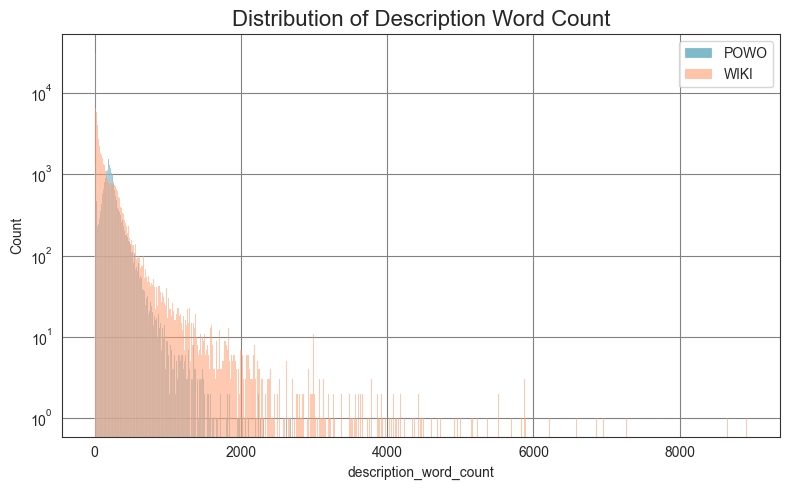

In [32]:
fig, ax = plt.subplots(figsize=(8,5), nrows = 1)
plt.title("Distribution of Description Word Count", fontsize=16)

for df_name, df in zip(["POWO", "WIKI"], [df_POWO_GIFT, df_WIKI_GIFT]): 
    sns.histplot(df["description_word_count"], alpha = 0.5, label = df_name)

# plt.xscale('log')
plt.yscale("log")
plt.legend()
plt.tight_layout()
plt.show()

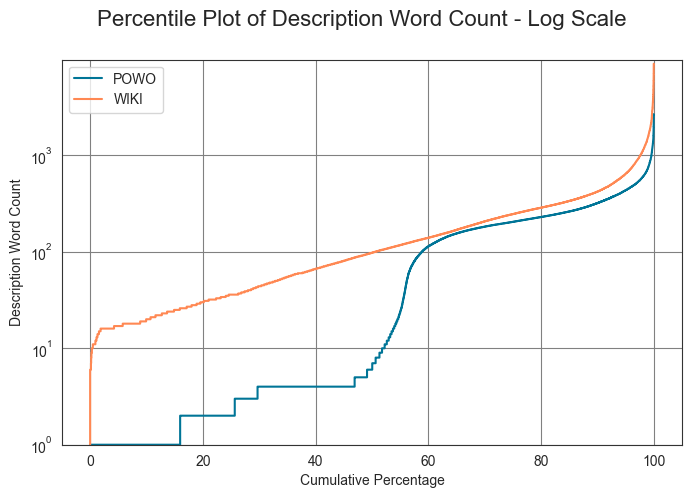

In [33]:
fig, ax = plt.subplots(figsize=(8,5), nrows = 1)
plt.suptitle("Percentile Plot of Description Word Count - Log Scale", fontsize=16)
for df_name, df in zip(["POWO", "WIKI"], [df_POWO_GIFT, df_WIKI_GIFT]): 
    sorted_data = np.sort(df["description_word_count"]) 
    plt.step(100*np.arange(sorted_data.size)/sorted_data.size, sorted_data, label = df_name)

plt.xlabel("Cumulative Percentage")
plt.ylabel("Description Word Count")
plt.yscale("log")
plt.ylim(1, np.max(sorted_data)*1.1)
plt.legend()
plt.show()

# Word Corpus Analysis

In [35]:
description_corpus = dict()
for df_name, df in zip(["POWO", "WIKI"], [df_POWO_GIFT, df_WIKI_GIFT]): 
    description_corpus[df_name] = " ".join(df["BERT_description"].values.astype(str))

In [36]:
word_Freq = dict()
for df_name, df in zip(["POWO", "WIKI"], [df_POWO_GIFT, df_WIKI_GIFT]): 
    word_Freq[df_name] = FreqDist(ngrams(nltk.word_tokenize(description_corpus[df_name]), 1))

In [38]:
for df_name, df in zip(["POWO", "WIKI"], [df_POWO_GIFT, df_WIKI_GIFT]): 
    print("Dataset {}".format(df_name))
    print("\tNumber of Unique Tokens in Corpus: {}".format(len(word_Freq[df_name])))

Dataset POWO
	Number of Unique Tokens in Corpus: 52336
Dataset WIKI
	Number of Unique Tokens in Corpus: 211328


## Token Occurrence
In the POWO dataset 44% of the tokens occur only once and 80% of the tokens occur less than 10 times.
 
In the WIKI dataset 48% of the tokens occur only once and 84% of the tokens occur less than 10 times. (This is probably due to the fact that species names are contained in some descriptions).

POWO
1% 1, 2% 1, 3% 1, 4% 1, 5% 1, 6% 1, 7% 1, 8% 1, 9% 1, 10% 1, 
11% 1, 12% 1, 13% 1, 14% 1, 15% 1, 16% 1, 17% 1, 18% 1, 19% 1, 20% 1, 
21% 1, 22% 1, 23% 1, 24% 1, 25% 1, 26% 1, 27% 1, 28% 1, 29% 1, 30% 1, 
31% 1, 32% 1, 33% 1, 34% 1, 35% 1, 36% 1, 37% 1, 38% 1, 39% 1, 40% 1, 
41% 1, 42% 1, 43% 1, 44% 1, 45% 2, 46% 2, 47% 2, 48% 2, 49% 2, 50% 2, 
51% 2, 52% 2, 53% 2, 54% 2, 55% 2, 56% 2, 57% 2, 58% 2, 59% 3, 60% 3, 
61% 3, 62% 3, 63% 3, 64% 3, 65% 3, 66% 4, 67% 4, 68% 4, 69% 4, 70% 4, 
71% 5, 72% 5, 73% 5, 74% 6, 75% 6, 76% 7, 77% 7, 78% 8, 79% 9, 80% 9, 
81% 10, 82% 11, 83% 12, 84% 14, 85% 15, 86% 17, 87% 19, 88% 23, 89% 27, 90% 32, 
91% 39, 92% 48, 93% 61, 94% 83, 95% 118, 96% 182, 97% 324, 98% 663, 99% 1780, 100% 284807, 

WIKI
1% 1, 2% 1, 3% 1, 4% 1, 5% 1, 6% 1, 7% 1, 8% 1, 9% 1, 10% 1, 
11% 1, 12% 1, 13% 1, 14% 1, 15% 1, 16% 1, 17% 1, 18% 1, 19% 1, 20% 1, 
21% 1, 22% 1, 23% 1, 24% 1, 25% 1, 26% 1, 27% 1, 28% 1, 29% 1, 30% 1, 
31% 1, 32% 1, 33% 1, 34% 1, 35% 1, 36% 1, 37% 1, 38% 

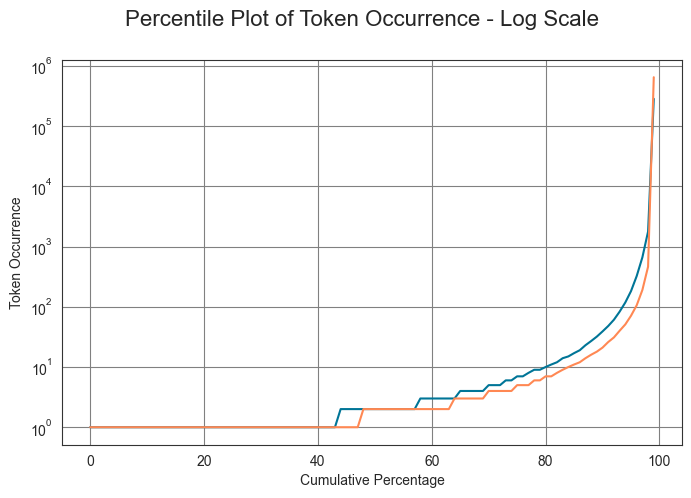

In [40]:
fig, ax = plt.subplots(figsize=(8,5), nrows = 1)
     
for df_name, df in zip(["POWO", "WIKI"], [df_POWO_GIFT, df_WIKI_GIFT]): 
    print(df_name)
    word_Frequencies = list(word_Freq[df_name].values())
    percentile_data = []
    for percentile in np.arange(1,101,1):
        percentile_data.append(np.percentile(word_Frequencies, percentile))
        print(str(percentile)+"%", int(np.percentile(word_Frequencies, percentile)), end=", ")
        if(percentile%10==0):
            print()
    plt.plot(percentile_data[:])
    print()
    
plt.suptitle("Percentile Plot of Token Occurrence - Log Scale", fontsize=16)
plt.xlabel("Cumulative Percentage")
plt.ylabel("Token Occurrence")
plt.yscale("log")
plt.show()

## Word Cloud

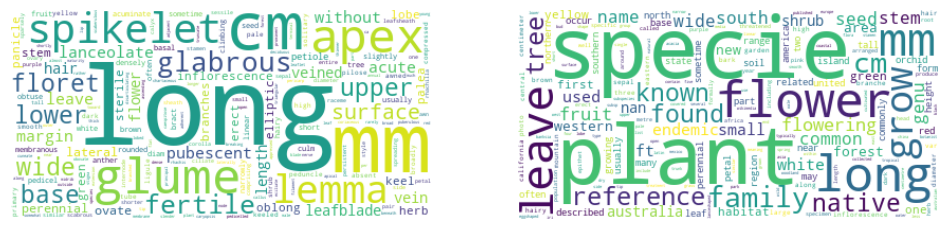

In [44]:
plt.subplots(figsize=(12,9), ncols = 2)
for i, (df_name, df) in enumerate(zip(["POWO", "WIKI"], [df_POWO_GIFT, df_WIKI_GIFT])): 
    plt.subplot(1, 2, i+1)
    wc = WordCloud(collocations=False, background_color="white").generate_from_text(description_corpus[df_name])
    plt.imshow(wc, interpolation="bilinear")
    plt.axis('off')
plt.show()

## Other Information

In [47]:
for i, (df_name, df) in enumerate(zip(["POWO", "WIKI"], [df_POWO_GIFT, df_WIKI_GIFT])): 
    print("Dataset {}".format(df_name))
    print("\tNumber of descriptions containing measurements (mm, cm, ft, dm): {}".format(np.sum(df["BERT_description"].apply(lambda x: (" mm " in str(x)) or (" cm " in str(x)) or (" dm " in str(x)) or (" m " in str(x)) or (" ft " in str(x))))))

Dataset POWO
	Number of descriptions containing measurements (mm, cm, ft, dm): 27135
Dataset WIKI
	Number of descriptions containing measurements (mm, cm, ft, dm): 22738


# Trait Analysis

In [7]:
trait_names_cat = ["Growth_form_1", "Epiphyte_1", "Climber_1", "Lifecycle_1", "Life_form_1"]
traits_cat = ["1.2.1", "1.3.1", "1.4.1", "2.1.1", "2.3.1"]

trait_names_num = ["Plant_height_max", "Leaf_length_max", "Leaf_width_max"]
traits_num = ["1.6.2", "4.6.2", "4.7.2"]

In [28]:
x_values = trait_names_cat + trait_names_num + trait_names_cat + trait_names_num
y_values = [np.sum(df_POWO_GIFT[trait].notna()) for trait in traits_cat + traits_num] + [np.sum(df_WIKI_GIFT[trait].notna()) for trait in traits_cat + traits_num]
y_coverage = [np.round(100*np.sum(df_POWO_GIFT[trait].notna())/df_POWO_GIFT.shape[0], 1) for trait in traits_cat + traits_num] + [np.round(100*np.sum(df_WIKI_GIFT[trait].notna())/df_WIKI_GIFT.shape[0], 1) for trait in traits_cat + traits_num]
hue = ["POWO"]*8 + ["WIKI"]*8

In [29]:
df_trait_coverage = pd.DataFrame(np.vstack([hue, x_values, y_values, y_coverage]).T, columns = ["Dataset", "Trait Name", "Trait Count", "Trait Coverage"])
df_trait_coverage

,Dataset,Trait Name,Trait Count,Trait Coverage
0,POWO,Growth_form_1,46110,78.0
1,POWO,Epiphyte_1,44417,75.1
2,POWO,Climber_1,45608,77.1
3,POWO,Lifecycle_1,36361,61.5
4,POWO,Life_form_1,21400,36.2
5,POWO,Plant_height_max,17648,29.8
6,POWO,Leaf_length_max,3397,5.7
7,POWO,Leaf_width_max,2243,3.8
8,WIKI,Growth_form_1,49535,89.0
9,WIKI,Epiphyte_1,45022,80.9


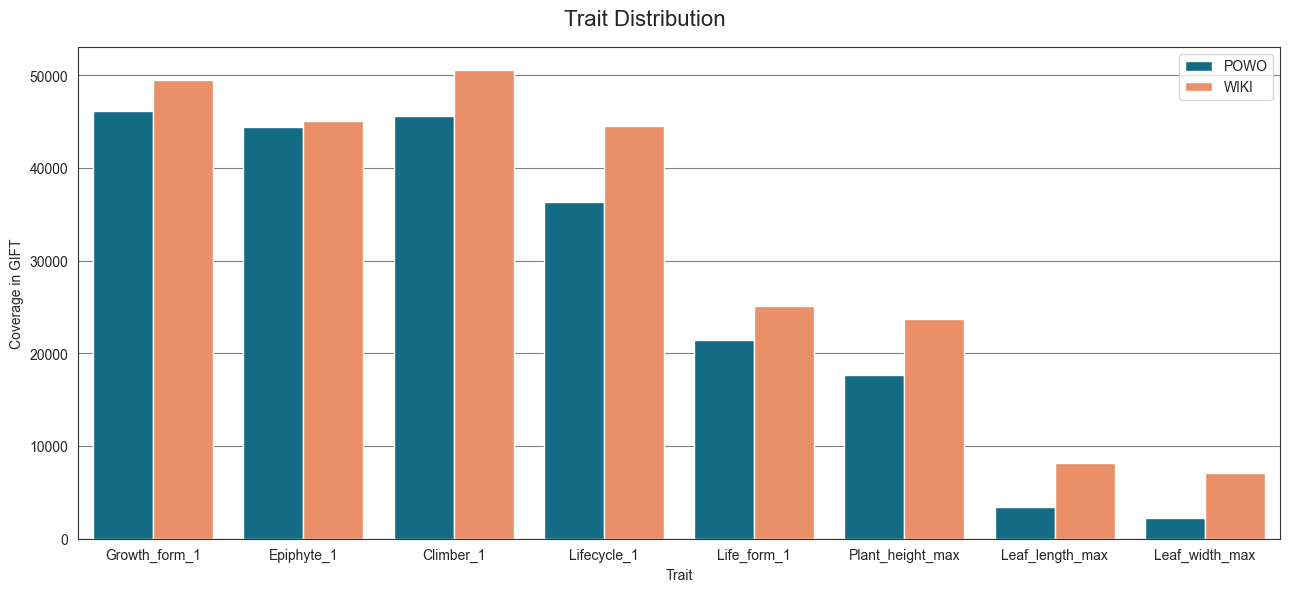

In [66]:
x_values = trait_names_cat + trait_names_num + trait_names_cat + trait_names_num
y_values = [np.sum(df_POWO_GIFT[trait].notna()) for trait in traits_cat + traits_num] + [np.sum(df_WIKI_GIFT[trait].notna()) for trait in traits_cat + traits_num]
hue = ["POWO"]*8 + ["WIKI"]*8

fig, ax = plt.subplots(figsize=(13,6), nrows = 1)
plt.suptitle("Trait Distribution", fontsize=16)
plt.xlabel("Trait")
plt.ylabel("Coverage in GIFT")
sns.barplot(y = y_values, x = x_values, hue = hue)
plt.tight_layout()
plt.show()

# Categorical Trait Analysis

In [17]:
trait_values_dict = {}
trait_values_dict["1.2.1"] = ["herb", "shrub", "tree"]
trait_values_dict["1.3.1"] = ["obligatory", "terrestrial"]
trait_values_dict["1.4.1"] = ["obligatory", "self-supporting"]
trait_values_dict["2.1.1"] = ["annual", "perennial"]
trait_values_dict["2.3.1"] = ["phanerophyte", "chamaephyte", "hemicryptophyte", "cryptophyte", "therophyte"]

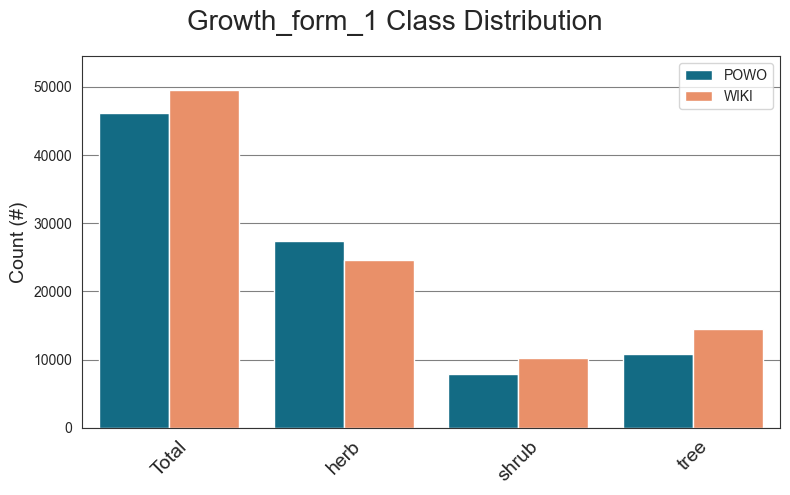

,Dataset,Trait Name,Trait Count,Trait Coverage
0,POWO,Total,46110,1.0
1,POWO,herb,27340,59.3
2,POWO,shrub,7883,17.1
3,POWO,tree,10846,23.5
4,WIKI,Total,49535,1.0
5,WIKI,herb,24655,49.8
6,WIKI,shrub,10314,20.8
7,WIKI,tree,14526,29.3


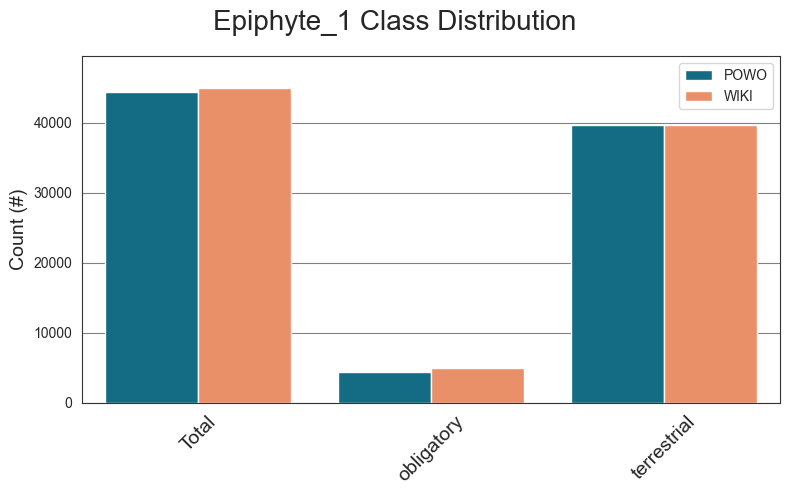

,Dataset,Trait Name,Trait Count,Trait Coverage
0,POWO,Total,44417,1.0
1,POWO,obligatory,4342,9.8
2,POWO,terrestrial,39656,89.3
3,WIKI,Total,45022,1.0
4,WIKI,obligatory,4976,11.1
5,WIKI,terrestrial,39696,88.2


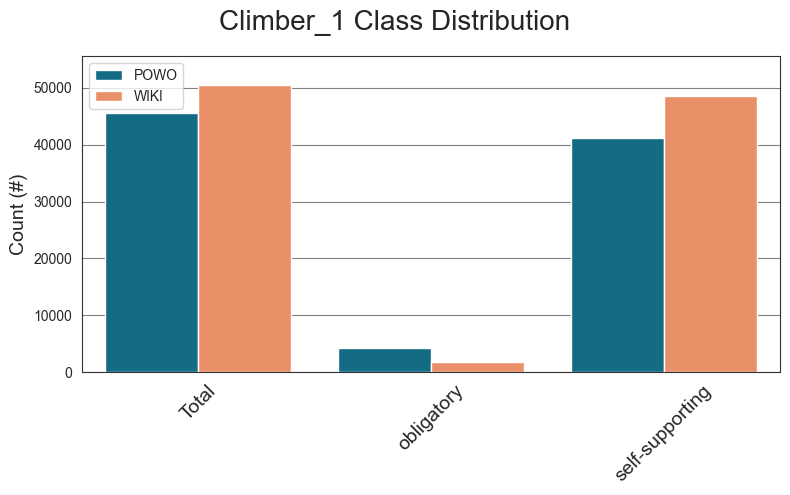

,Dataset,Trait Name,Trait Count,Trait Coverage
0,POWO,Total,45608,1.0
1,POWO,obligatory,4328,9.5
2,POWO,self-supporting,41156,90.2
3,WIKI,Total,50517,1.0
4,WIKI,obligatory,1789,3.5
5,WIKI,self-supporting,48633,96.3


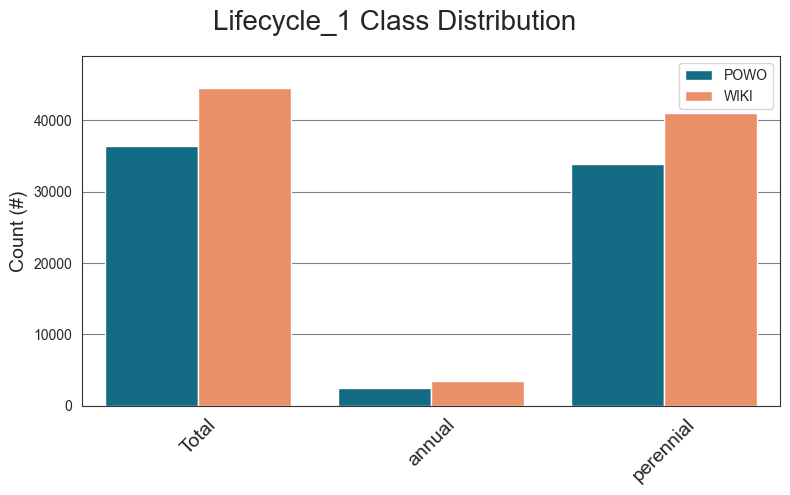

,Dataset,Trait Name,Trait Count,Trait Coverage
0,POWO,Total,36361,1.0
1,POWO,annual,2475,6.8
2,POWO,perennial,33859,93.1
3,WIKI,Total,44569,1.0
4,WIKI,annual,3398,7.6
5,WIKI,perennial,41005,92.0


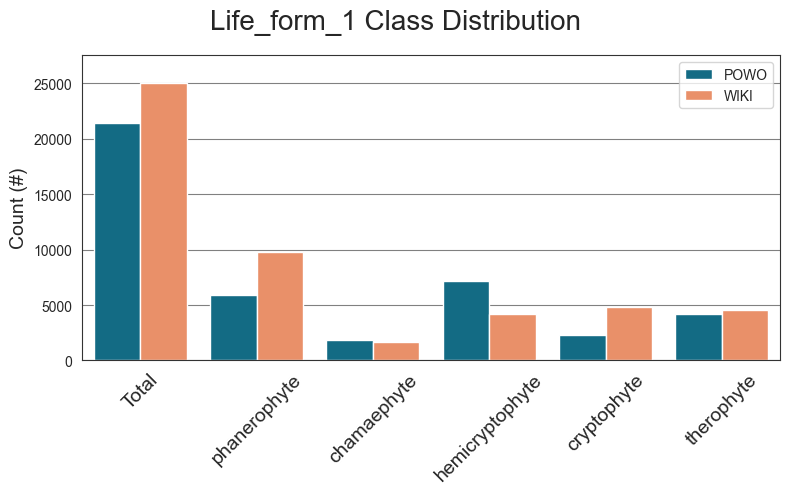

,Dataset,Trait Name,Trait Count,Trait Coverage
0,POWO,Total,21400,1.0
1,POWO,phanerophyte,5922,27.7
2,POWO,chamaephyte,1824,8.5
3,POWO,hemicryptophyte,7195,33.6
4,POWO,cryptophyte,2290,10.7
5,POWO,therophyte,4169,19.5
6,WIKI,Total,25048,1.0
7,WIKI,phanerophyte,9790,39.1
8,WIKI,chamaephyte,1691,6.8
9,WIKI,hemicryptophyte,4147,16.6


In [30]:
for trait_name, trait_code in zip(trait_names_cat, traits_cat):
    fig, axes  = plt.subplots(figsize=(8,5), nrows = 1)

    x_values = ["Total"] + trait_values_dict[trait_code] + ["Total"] + trait_values_dict[trait_code]
    y_values = [df_POWO_GIFT[trait_code].count()] + list(df_POWO_GIFT[trait_code].value_counts()[trait_values_dict[trait_code]]) + [df_WIKI_GIFT[trait_code].count()] + list(df_WIKI_GIFT[trait_code].value_counts()[trait_values_dict[trait_code]])
    y_coverage = [1] + list(np.round(100*df_POWO_GIFT[trait_code].value_counts()[trait_values_dict[trait_code]]/df_POWO_GIFT[trait_code].count(), 1)) + [1] + list(np.round(100*df_WIKI_GIFT[trait_code].value_counts()[trait_values_dict[trait_code]]/df_WIKI_GIFT[trait_code].count(), 1))

    hue = ["POWO"]*(len(x_values)//2) + ["WIKI"]*(len(x_values)//2)
    sns.barplot(y = y_values, x = x_values, hue = hue)
    axes.set_xticklabels(axes.get_xticklabels(), size=14, rotation=45)

    plt.ylim(0, df_WIKI_GIFT[trait_code].count()*1.1)
    plt.ylabel("Count (#)", size=14)
    plt.suptitle("{} Class Distribution".format(trait_name), size=20)
    plt.tight_layout()
    plt.show()
    
    df_trait_class_coverage = pd.DataFrame(np.vstack([hue, x_values, y_values, y_coverage]).T, columns = ["Dataset", "Trait Name", "Trait Count", "Trait Coverage"])
    display(df_trait_class_coverage)

# Numerical Trait Analysis

POWO Plant_height_max 7.42 10.67
WIKI Plant_height_max 6.67 10.82


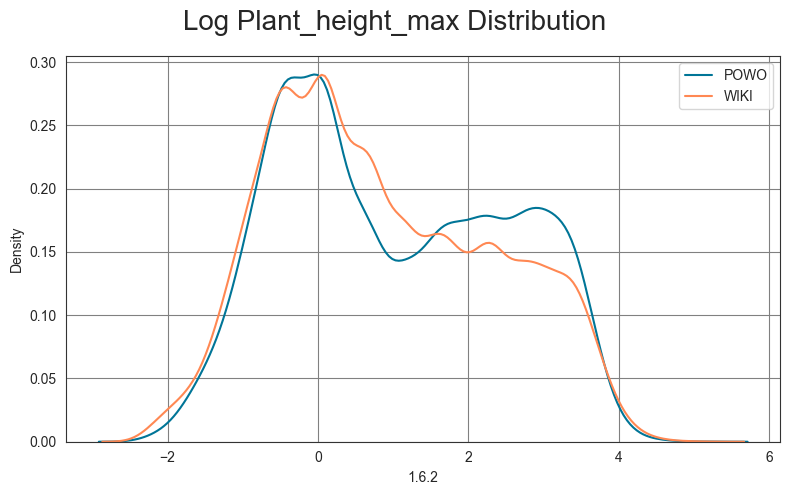

POWO Leaf_length_max 12.87 31.06
WIKI Leaf_length_max 16.1 103.87


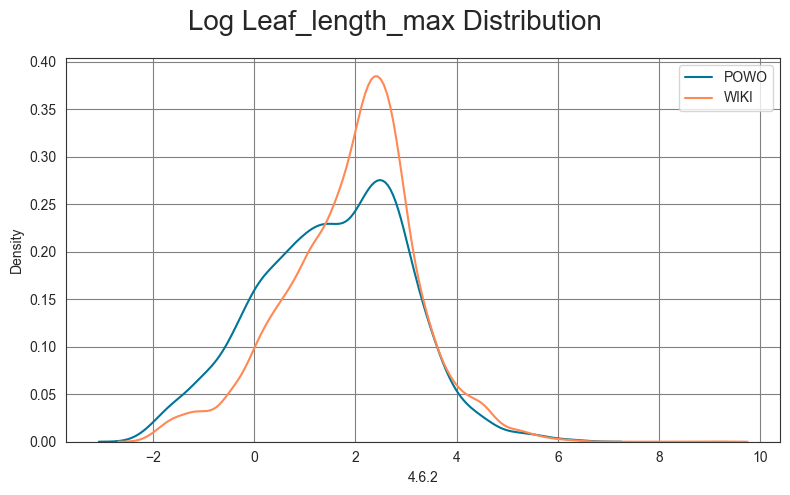

POWO Leaf_width_max 6.54 95.43
WIKI Leaf_width_max 4.92 53.87


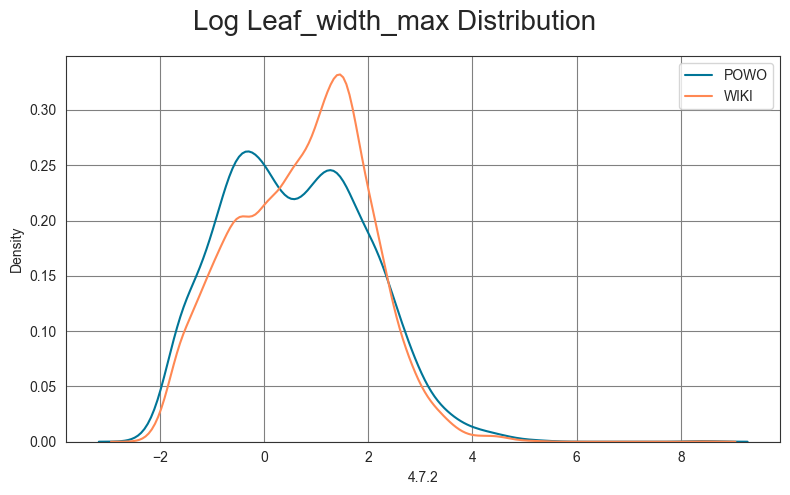

In [32]:
for trait_name, trait_code in zip(trait_names_num, traits_num):
    fig, axes  = plt.subplots(figsize=(8,5), nrows = 1)

    for i, (df_name, df) in enumerate(zip(["POWO", "WIKI"], [df_POWO_GIFT, df_WIKI_GIFT])): 
        sns.kdeplot(np.log(df[df[trait_code].notna()][trait_code]+0.1), label = df_name)
        print(df_name, trait_name, np.round(np.mean(df[df[trait_code].notna()][trait_code]), 2), np.round(np.std(df[df[trait_code].notna()][trait_code]), 2))
    plt.suptitle("Log {} Distribution".format(trait_name), size=20)
    # plt.xscale("log")
    plt.tight_layout()
    plt.legend()
    plt.show()

# Geographic Distribution

## Combine Datasets with Geographic Information

In [35]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
POWO_world = gpd.read_file("../Data/Geographic Data/TDWG/level3/level3.shp")
geo_GIFT = pyreadr.read_r("../Data/Geographic Data/powo_GIFT_list.RData")["powo_checklist"]
geo_GIFT = geo_GIFT[["list_ID", "species"]].drop_duplicates()

In [36]:
POWO_world

,IDforGIFT,LEVEL3_COD,LEVEL3_NAM,LEVEL2_COD,LEVEL1_COD,geometry
0,ABT,ABT,Alberta,71.0,7.0,"POLYGON ((-114.86111 50.40610, -114.86444 50.4..."
1,AFG,AFG,Afghanistan,34.0,3.0,"POLYGON ((71.25447 38.30291, 71.26777 38.30211..."
2,AGE,AGE,Argentina Northeast,85.0,8.0,"MULTIPOLYGON (((-61.87886 -39.24249, -61.89336..."
3,AGS,AGS,Argentina South,85.0,8.0,"MULTIPOLYGON (((-68.60866 -54.89139, -68.62056..."
4,AGW,AGW,Argentina Northwest,85.0,8.0,"POLYGON ((-65.74806 -22.11169, -65.73416 -22.1..."
...,...,...,...,...,...,...
364,YUG,YUG,Yugoslavia,13.0,1.0,"MULTIPOLYGON (((16.90384 42.72611, 16.89444 42..."
365,YUK,YUK,Yukon,70.0,7.0,"MULTIPOLYGON (((-136.42081 68.90159, -136.4205..."
366,ZAI,ZAI,Zaïre,23.0,2.0,"MULTIPOLYGON (((12.95307 -5.87609, 12.93357 -5..."
367,ZAM,ZAM,Zambia,26.0,2.0,"POLYGON ((31.11947 -8.61499, 31.13277 -8.61559..."


In [37]:
geo_GIFT

,list_ID,species
0,ETH,Acanthopale aethiogermanica
1,ETH,Acanthopale pubescens
2,ETH,Acanthus eminens
3,ETH,Acanthus polystachyus
4,ETH,Acanthus sennii
...,...,...
1850347,ANT,Deschampsia antarctica
1850348,ANT,Deschampsia parvula
1850349,ANT,Poa annua
1850351,SSA,Deschampsia antarctica


In [42]:
df_POWO_GIFT_Geo_tmp = combine_description_geo_data(df_POWO_GIFT, geo_GIFT)
df_POWO_GIFT_Geo = combine_description_geometry(df_POWO_GIFT_Geo_tmp, POWO_world)
df_POWO_GIFT_Geo = gpd.GeoDataFrame(df_POWO_GIFT_Geo, crs="EPSG:4326", geometry=df_POWO_GIFT_Geo["geometry"])

In [72]:
df_WIKI_GIFT_Geo_tmp = combine_description_geo_data(df_WIKI_GIFT, geo_GIFT)
df_WIKI_GIFT_Geo = combine_description_geometry(df_WIKI_GIFT_Geo_tmp, POWO_world)
df_WIKI_GIFT_Geo = gpd.GeoDataFrame(df_WIKI_GIFT_Geo, crs="EPSG:4326", geometry=df_WIKI_GIFT_Geo["geometry"])

In [43]:
df_POWO_GIFT_Geo

,name,authors,POWO_ids,POWO_id_N,Language,description,QA_description,BERT_description,BOW_description,description_character_count,...,4.7.2_agreement,4.7.2_bias_by_reference,4.7.2_bias_by_derivation,list_ID,IDforGIFT,LEVEL3_COD,LEVEL3_NAM,LEVEL2_COD,LEVEL1_COD,geometry
0,Aa argyrolepis,Rchb.f.,morphologyGeneralHabit,1,es,Hierba,herb,herb,herb,4,...,NaN,NaN,NaN,ECU,ECU,ECU,Ecuador,83.0,8.0,"MULTIPOLYGON (((-80.19333 -3.03469, -80.21143 ..."
1,Aa argyrolepis,Rchb.f.,morphologyGeneralHabit,1,es,Hierba,herb,herb,herb,4,...,NaN,NaN,NaN,PER,PER,PER,Peru,83.0,8.0,"POLYGON ((-75.02143 -0.12309, -74.96053 -0.170..."
2,Aa argyrolepis,Rchb.f.,morphologyGeneralHabit,1,es,Hierba,herb,herb,herb,4,...,NaN,NaN,NaN,CLM,CLM,CLM,Colombia,83.0,8.0,"MULTIPOLYGON (((-78.54433 2.41531, -78.54923 2..."
3,Aa argyrolepis,Rchb.f.,morphologyGeneralHabit,1,es,Hierba,herb,herb,herb,4,...,NaN,NaN,NaN,BZN,BZN,BZN,Brazil North,84.0,8.0,"MULTIPOLYGON (((-51.04816 -1.96729, -51.10946 ..."
4,Aa colombiana,Schltr.,morphologyGeneralHabit,1,es,Hierba,herb,herb,herb,4,...,NaN,NaN,NaN,ECU,ECU,ECU,Ecuador,83.0,8.0,"MULTIPOLYGON (((-80.19333 -3.03469, -80.21143 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
439595,× Dupoa labradorica,(Steud.) J.Cay. & Darbysh.,morphologyReproductiveInflorescenceBractGlume;...,7,en,Glumes persistent; similar; shorter than spike...,glumes persistent ; similar ; shorter than spi...,glumes persistent similar shorter than spikele...,glumes persistent similar shorter spikelet fir...,1422,...,NaN,NaN,NaN,ASK,ASK,ASK,Alaska,70.0,7.0,"MULTIPOLYGON (((-162.40053 54.36941, -162.4322..."
439596,× Dupoa labradorica,(Steud.) J.Cay. & Darbysh.,morphologyReproductiveInflorescenceBractGlume;...,7,en,Glumes persistent; similar; shorter than spike...,glumes persistent ; similar ; shorter than spi...,glumes persistent similar shorter than spikele...,glumes persistent similar shorter spikelet fir...,1422,...,NaN,NaN,NaN,NWT,NWT,NWT,Northwest Territories,70.0,7.0,"MULTIPOLYGON (((-135.87043 68.89011, -135.8464..."
439597,× Dupoa labradorica,(Steud.) J.Cay. & Darbysh.,morphologyReproductiveInflorescenceBractGlume;...,7,en,Glumes persistent; similar; shorter than spike...,glumes persistent ; similar ; shorter than spi...,glumes persistent similar shorter than spikele...,glumes persistent similar shorter spikelet fir...,1422,...,NaN,NaN,NaN,QUE,QUE,QUE,Québec,72.0,7.0,"MULTIPOLYGON (((-79.53735 50.98376, -79.53751 ..."
439598,× Dupoa labradorica,(Steud.) J.Cay. & Darbysh.,morphologyReproductiveInflorescenceBractGlume;...,7,en,Glumes persistent; similar; shorter than spike...,glumes persistent ; similar ; shorter than spi...,glumes persistent similar shorter than spikele...,glumes persistent similar shorter spikelet fir...,1422,...,NaN,NaN,NaN,LAB,LAB,LAB,Labrador,72.0,7.0,"MULTIPOLYGON (((-55.76303 53.02941, -55.85333 ..."


In [73]:
df_WIKI_GIFT_Geo

,name,authors,WIKI_ids,WIKI_id_N,Language,description,QA_description,BERT_description,BOW_description,description_character_count,...,4.7.2_agreement,4.7.2_bias_by_reference,4.7.2_bias_by_derivation,list_ID,IDforGIFT,LEVEL3_COD,LEVEL3_NAM,LEVEL2_COD,LEVEL1_COD,geometry
0,Aa achalensis,"Schltr., 1920",Summary;Summary,2,en,Aa achalensis is a species of orchid in the ge...,aa achalensis is a species of orchid in the ge...,aa achalensis is species of orchid in the genu...,aa achalensis species orchid genus aa referenc...,123,...,NaN,NaN,NaN,AGW,AGW,AGW,Argentina Northwest,85.0,8.0,"POLYGON ((-65.74806 -22.11169, -65.73416 -22.1..."
1,Aa achalensis,"Schltr., 1920",Summary;Summary,2,en,Aa achalensis is a species of orchid in the ge...,aa achalensis is a species of orchid in the ge...,aa achalensis is species of orchid in the genu...,aa achalensis species orchid genus aa referenc...,123,...,NaN,NaN,NaN,AGE,AGE,AGE,Argentina Northeast,85.0,8.0,"MULTIPOLYGON (((-61.87886 -39.24249, -61.89336..."
2,Aa argyrolepis,"Rchb.f., 1854",Summary;References;Summary;References,4,en,Aa argyrolepis is an orchid in the genus Aa. ...,aa argyrolepis is an orchid in the genus aa . ...,aa argyrolepis is an orchid in the genus aa it...,aa argyrolepis orchid genus aa grows altitudes...,1077,...,NaN,NaN,NaN,ECU,ECU,ECU,Ecuador,83.0,8.0,"MULTIPOLYGON (((-80.19333 -3.03469, -80.21143 ..."
3,Aa argyrolepis,"Rchb.f., 1854",Summary;References;Summary;References,4,en,Aa argyrolepis is an orchid in the genus Aa. ...,aa argyrolepis is an orchid in the genus aa . ...,aa argyrolepis is an orchid in the genus aa it...,aa argyrolepis orchid genus aa grows altitudes...,1077,...,NaN,NaN,NaN,PER,PER,PER,Peru,83.0,8.0,"POLYGON ((-75.02143 -0.12309, -74.96053 -0.170..."
4,Aa argyrolepis,"Rchb.f., 1854",Summary;References;Summary;References,4,en,Aa argyrolepis is an orchid in the genus Aa. ...,aa argyrolepis is an orchid in the genus aa . ...,aa argyrolepis is an orchid in the genus aa it...,aa argyrolepis orchid genus aa grows altitudes...,1077,...,NaN,NaN,NaN,CLM,CLM,CLM,Colombia,83.0,8.0,"MULTIPOLYGON (((-78.54433 2.41531, -78.54923 2..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479223,Zygotritonia bongensis,(Pax) Mildbr.,Summary;Morphology;Distribution,3,en,Zygotritonia bongensis is a perennial herb of ...,zygotritonia bongensis is a perennial herb of ...,zygotritonia bongensis is perennial herb of th...,zygotritonia bongensis perennial herb iridacea...,745,...,NaN,NaN,NaN,MLI,MLI,MLI,Mali,22.0,2.0,"POLYGON ((-4.80613 25.00031, -4.52533 24.82501..."
479224,Zygotritonia bongensis,(Pax) Mildbr.,Summary;Morphology;Distribution,3,en,Zygotritonia bongensis is a perennial herb of ...,zygotritonia bongensis is a perennial herb of ...,zygotritonia bongensis is perennial herb of th...,zygotritonia bongensis perennial herb iridacea...,745,...,NaN,NaN,NaN,NGR,NGR,NGR,Niger,22.0,2.0,"POLYGON ((13.90917 22.88331, 14.23497 22.61421..."
479225,Zyzyxia lundellii,"(H.Robinson) Strother, 1991",Summary;Description and distribution;Naming,3,en,Zyzyxia is a genus of tropical shrubs in the f...,zyzyxia is a genus of tropical shrubs in the f...,zyzyxia is genus of tropical shrubs in the fam...,zyzyxia genus tropical shrubs family asteracea...,1626,...,NaN,NaN,NaN,BLZ,BLZ,BLZ,Belize,80.0,8.0,"MULTIPOLYGON (((-87.80333 17.29421, -87.80913 ..."
479226,Zyzyxia lundellii,"(H.Robinson) Strother, 1991",Summary;Description and distribution;Naming,3,en,Zyzyxia is a genus of tropical shrubs in the f...,zyzyxia is a genus of tropical shrubs in the f...,zyzyxia is genus of tropical shrubs in the fam...,zyzyxia genus tropical shrubs family asteracea...,1626,...,NaN,NaN,NaN,GUA,GUA,GUA,Guatemala,80.0,8.0,"POLYGON ((-89.74223 17.82081, -89.43043 17.819..."


## Aggregate Data to Level 3

In [75]:
df_POWO_GIFT_Geo_Level_3 = df_POWO_GIFT_Geo.groupby(['LEVEL3_COD']).size().reset_index(name='counts')
df_POWO_GIFT_Geo_Level_3_mean = df_POWO_GIFT_Geo[["LEVEL3_COD", "description_character_count", "description_word_count"]].groupby(['LEVEL3_COD']).mean().reset_index()[["LEVEL3_COD", "description_character_count", "description_word_count"]]
df_POWO_GIFT_Geo_Level_3 = df_POWO_GIFT_Geo_Level_3.merge(df_POWO_GIFT_Geo_Level_3_mean, on="LEVEL3_COD")
tmp = [gpd.GeoSeries(unary_union(df_POWO_GIFT_Geo[df_POWO_GIFT_Geo["LEVEL3_COD"]==i]["geometry"].drop_duplicates()) for i in df_POWO_GIFT_Geo_Level_3["LEVEL3_COD"])]
df_POWO_GIFT_Geo_Level_3["geometry"] = tmp[0]
df_POWO_GIFT_Geo_Level_3 = gpd.GeoDataFrame(df_POWO_GIFT_Geo_Level_3, crs="EPSG:4326", geometry=df_POWO_GIFT_Geo_Level_3["geometry"])
df_POWO_GIFT_Geo_Level_3

,LEVEL3_COD,counts,description_character_count,description_word_count,geometry
0,ABT,340,1489.561765,223.082353,"POLYGON ((-114.86111 50.40610, -114.86444 50.4..."
1,AFG,1154,1146.218371,174.378683,"POLYGON ((71.25447 38.30291, 71.26777 38.30211..."
2,AGE,2031,1047.683407,157.081733,"MULTIPOLYGON (((-61.89336 -39.24359, -61.90116..."
3,AGS,627,1257.430622,188.460925,"MULTIPOLYGON (((-68.64316 -54.88859, -68.63726..."
4,AGW,1683,1056.783125,157.423648,"POLYGON ((-65.74806 -22.11169, -65.73416 -22.1..."
...,...,...,...,...,...
363,YUG,1082,1330.910351,204.058226,"MULTIPOLYGON (((15.60884 43.67221, 15.60664 43..."
364,YUK,212,1347.198113,199.405660,"MULTIPOLYGON (((-136.42059 68.90155, -136.4206..."
365,ZAI,5999,1709.681280,262.705951,"MULTIPOLYGON (((12.93357 -5.88389, 12.92167 -5..."
366,ZAM,4971,2093.941259,320.639710,"POLYGON ((31.11947 -8.61499, 31.13277 -8.61559..."


In [74]:
df_WIKI_GIFT_Geo_Level_3 = df_WIKI_GIFT_Geo.groupby(['LEVEL3_COD']).size().reset_index(name='counts')
df_WIKI_GIFT_Geo_Level_3_mean = df_WIKI_GIFT_Geo[["LEVEL3_COD", "description_character_count", "description_word_count"]].groupby(['LEVEL3_COD']).mean().reset_index()[["LEVEL3_COD", "description_character_count", "description_word_count"]]
df_WIKI_GIFT_Geo_Level_3 = df_WIKI_GIFT_Geo_Level_3.merge(df_WIKI_GIFT_Geo_Level_3_mean, on="LEVEL3_COD")
tmp = [gpd.GeoSeries(unary_union(df_WIKI_GIFT_Geo[df_WIKI_GIFT_Geo["LEVEL3_COD"]==i]["geometry"].drop_duplicates()) for i in df_WIKI_GIFT_Geo_Level_3["LEVEL3_COD"])]
df_WIKI_GIFT_Geo_Level_3["geometry"] = tmp[0]
df_WIKI_GIFT_Geo_Level_3 = gpd.GeoDataFrame(df_WIKI_GIFT_Geo_Level_3, crs="EPSG:4326", geometry=df_WIKI_GIFT_Geo_Level_3["geometry"])
df_WIKI_GIFT_Geo_Level_3

,LEVEL3_COD,counts,description_character_count,description_word_count,geometry
0,ABT,1413,2192.949752,350.476292,"POLYGON ((-114.86111 50.40610, -114.86444 50.4..."
1,AFG,1073,2896.845294,464.289842,"POLYGON ((71.25447 38.30291, 71.26777 38.30211..."
2,AGE,1569,2496.976418,401.219248,"MULTIPOLYGON (((-61.89336 -39.24359, -61.90116..."
3,AGS,766,2745.212794,440.369452,"MULTIPOLYGON (((-68.64316 -54.88859, -68.63726..."
4,AGW,1201,2344.084929,375.799334,"POLYGON ((-65.74806 -22.11169, -65.73416 -22.1..."
...,...,...,...,...,...
363,YUG,2701,2339.389115,374.367642,"MULTIPOLYGON (((15.60884 43.67221, 15.60664 43..."
364,YUK,779,2099.008986,334.879332,"MULTIPOLYGON (((-136.42059 68.90155, -136.4206..."
365,ZAI,1678,2288.554827,367.866508,"MULTIPOLYGON (((12.93357 -5.88389, 12.92167 -5..."
366,ZAM,1154,2258.871750,363.451473,"POLYGON ((31.11947 -8.61499, 31.13277 -8.61559..."


<AxesSubplot:>

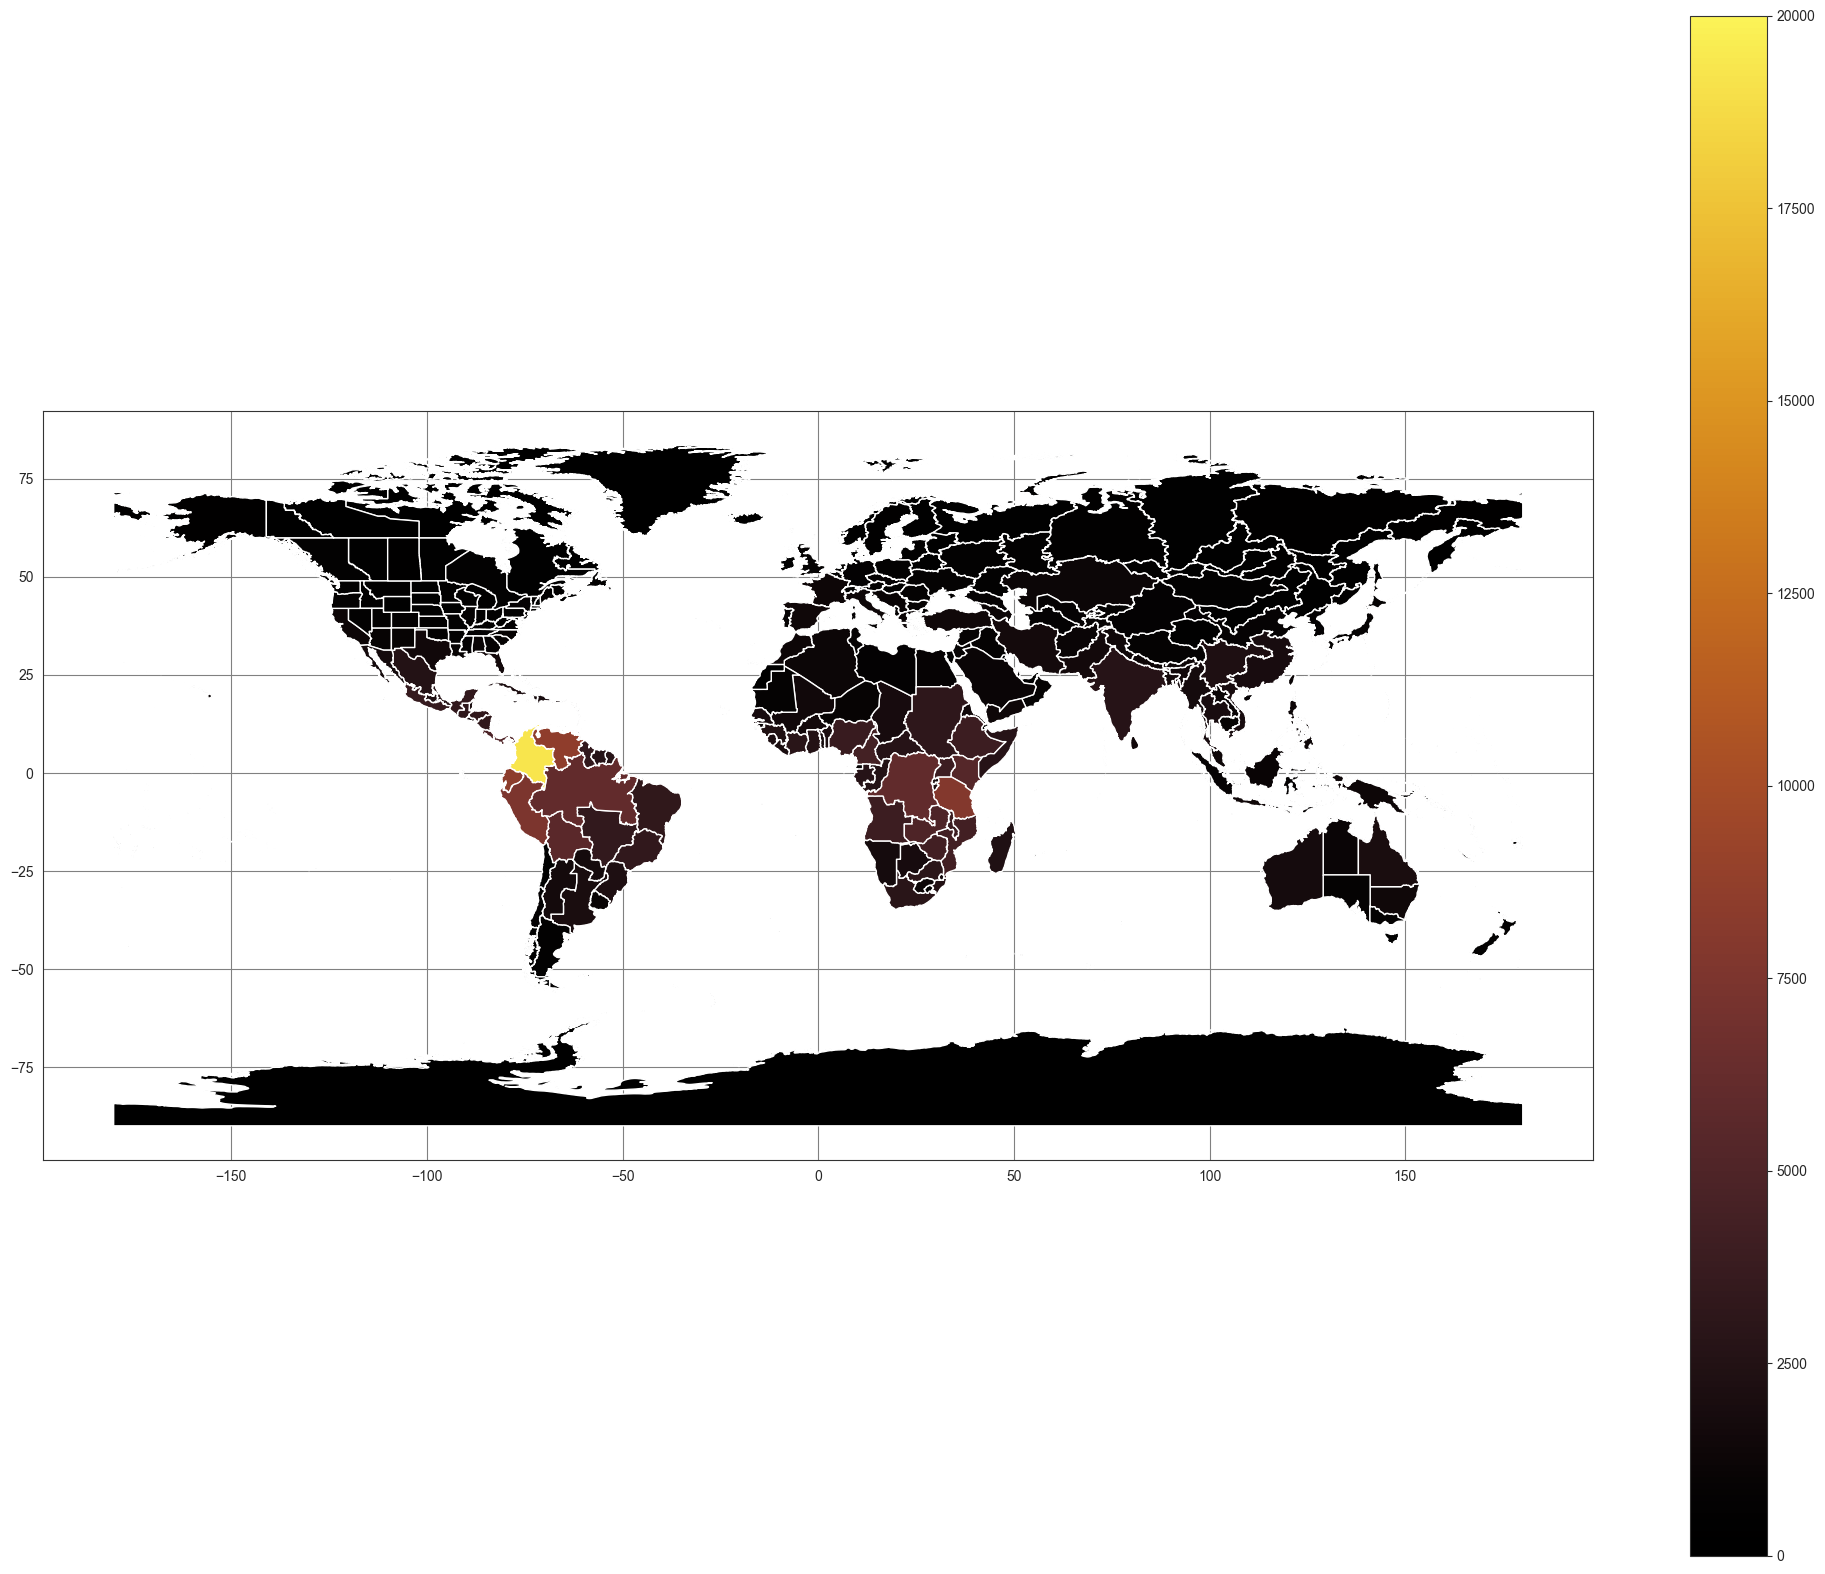

In [87]:
df_POWO_GIFT_Geo_Level_3.plot(figsize=(25, 20), column = "counts", 
           legend=True,cmap=cmap, vmin = 0, vmax = 20000)

<AxesSubplot:>

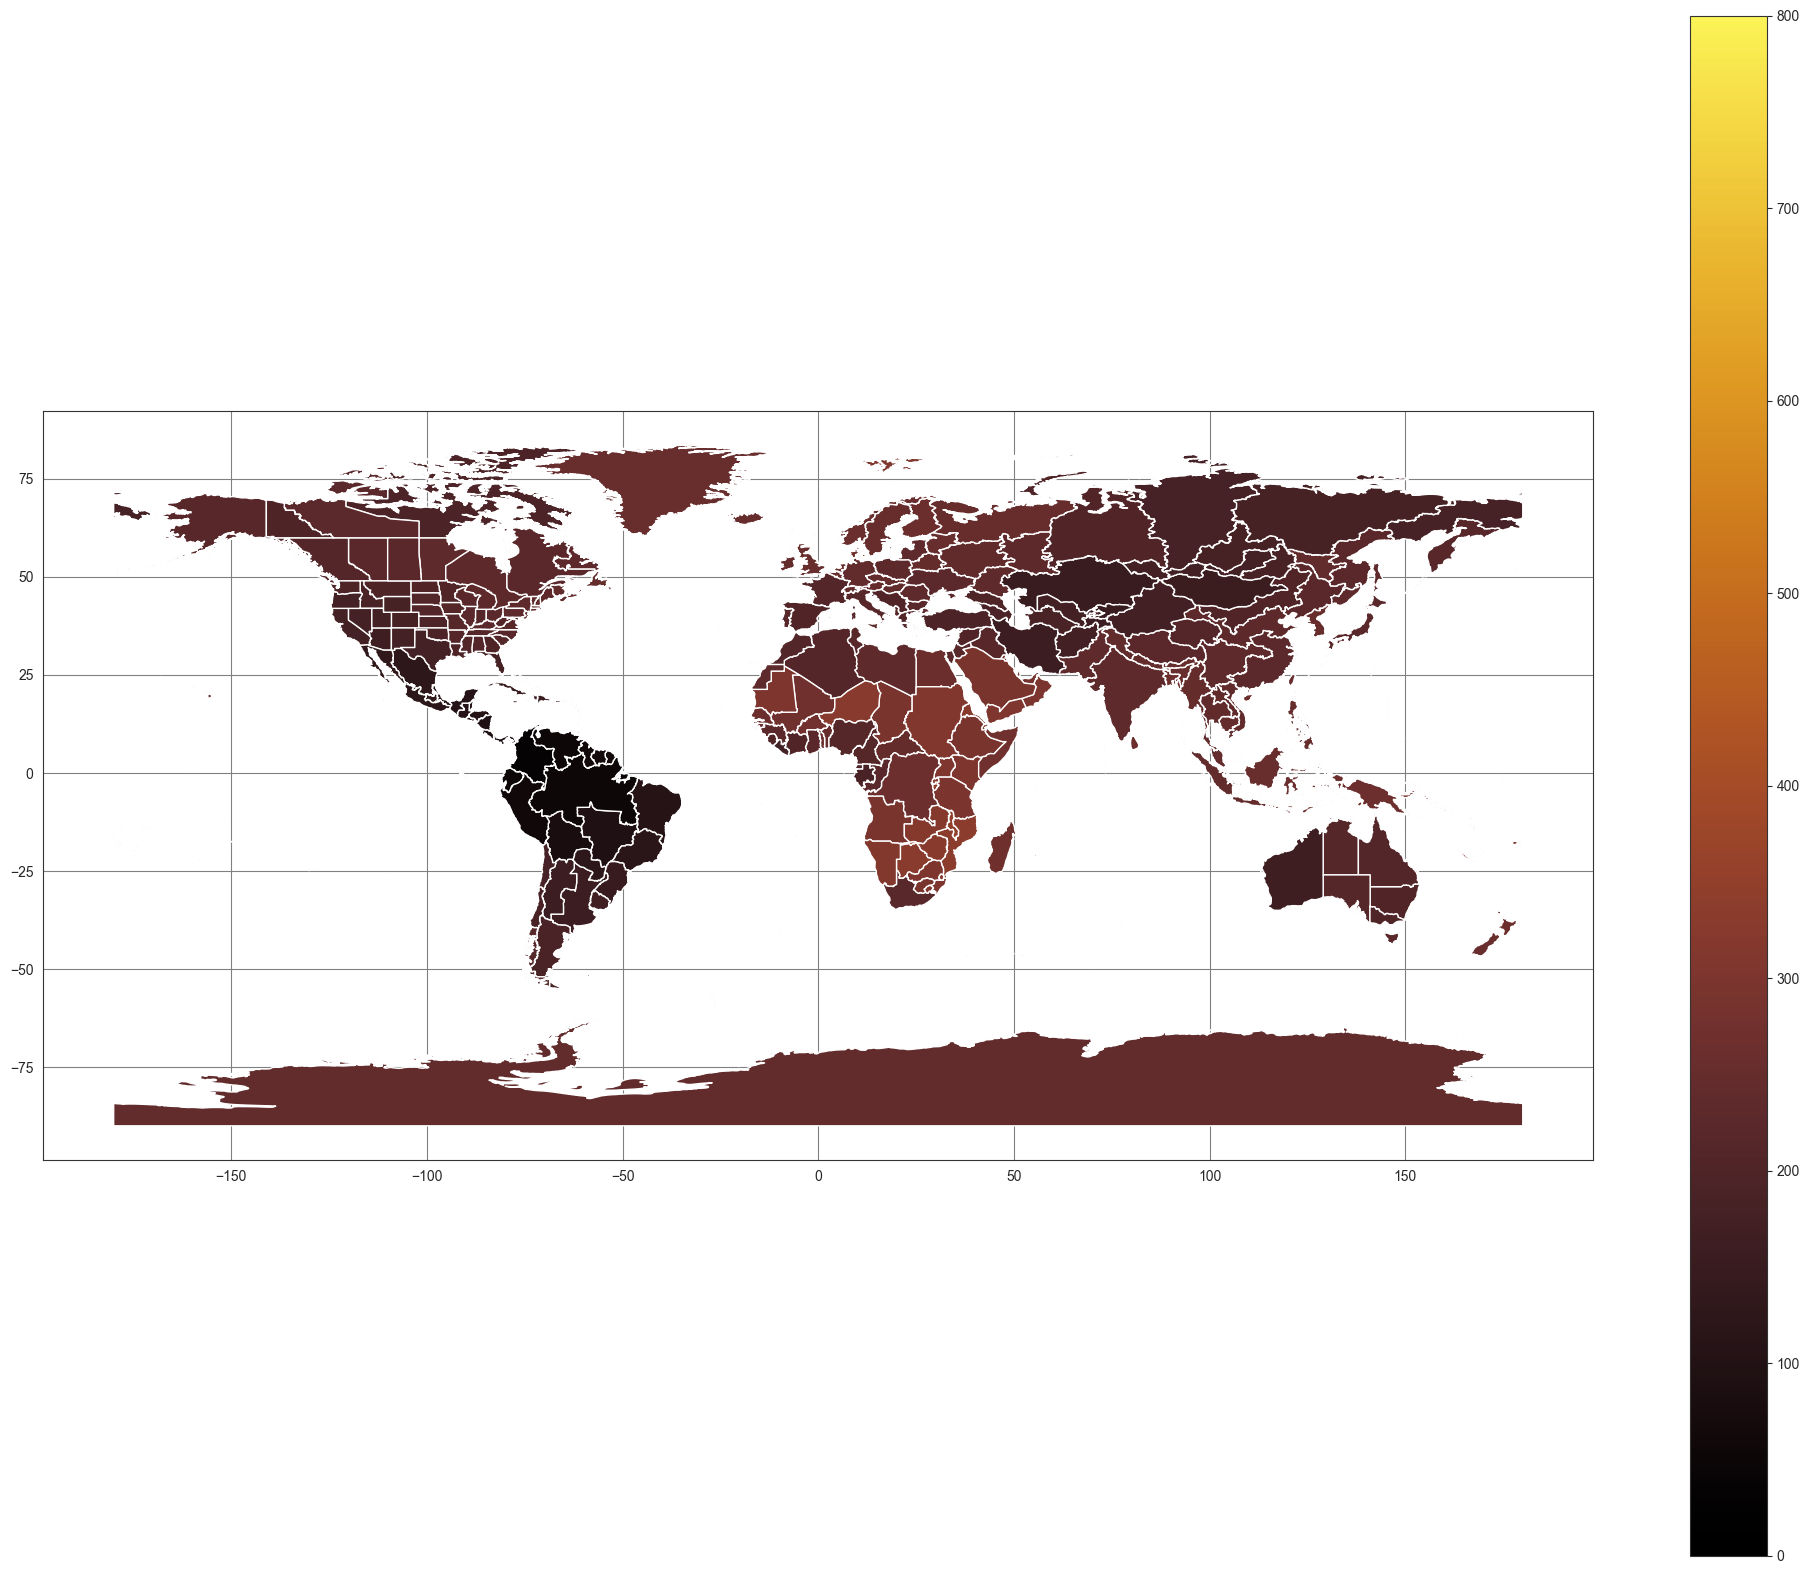

In [93]:
df_POWO_GIFT_Geo_Level_3.plot(figsize=(25, 20), column = "description_word_count", 
           legend=True,cmap=cmap, vmin = 0, vmax = 800)

<AxesSubplot:>

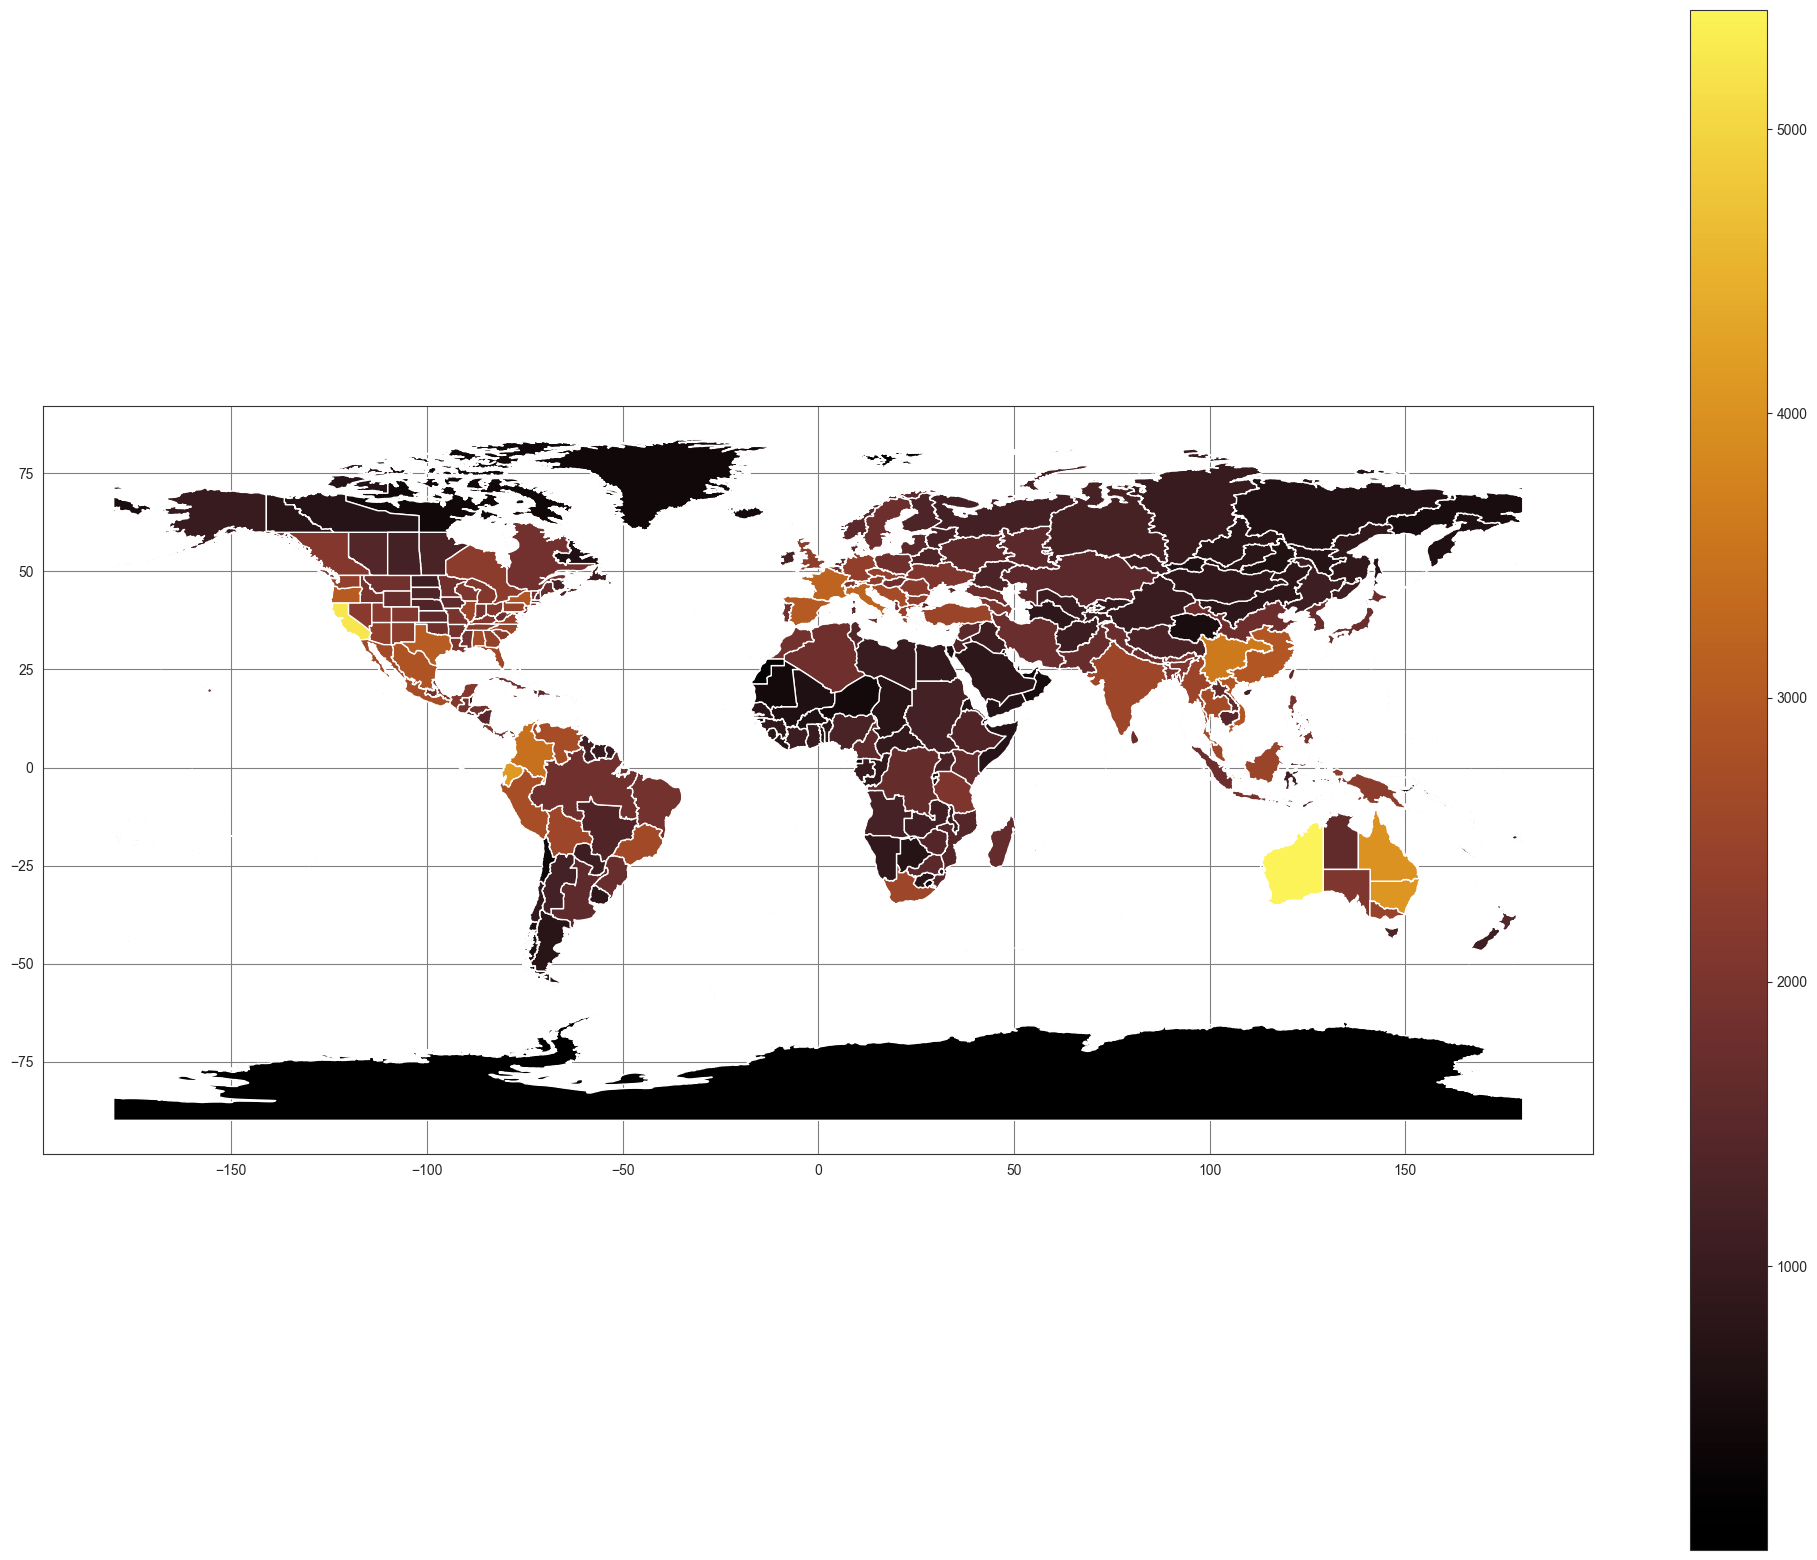

In [90]:
df_WIKI_GIFT_Geo_Level_3.plot(figsize=(25, 20), column = "counts", 
           legend=True,cmap=cmap)

<AxesSubplot:>

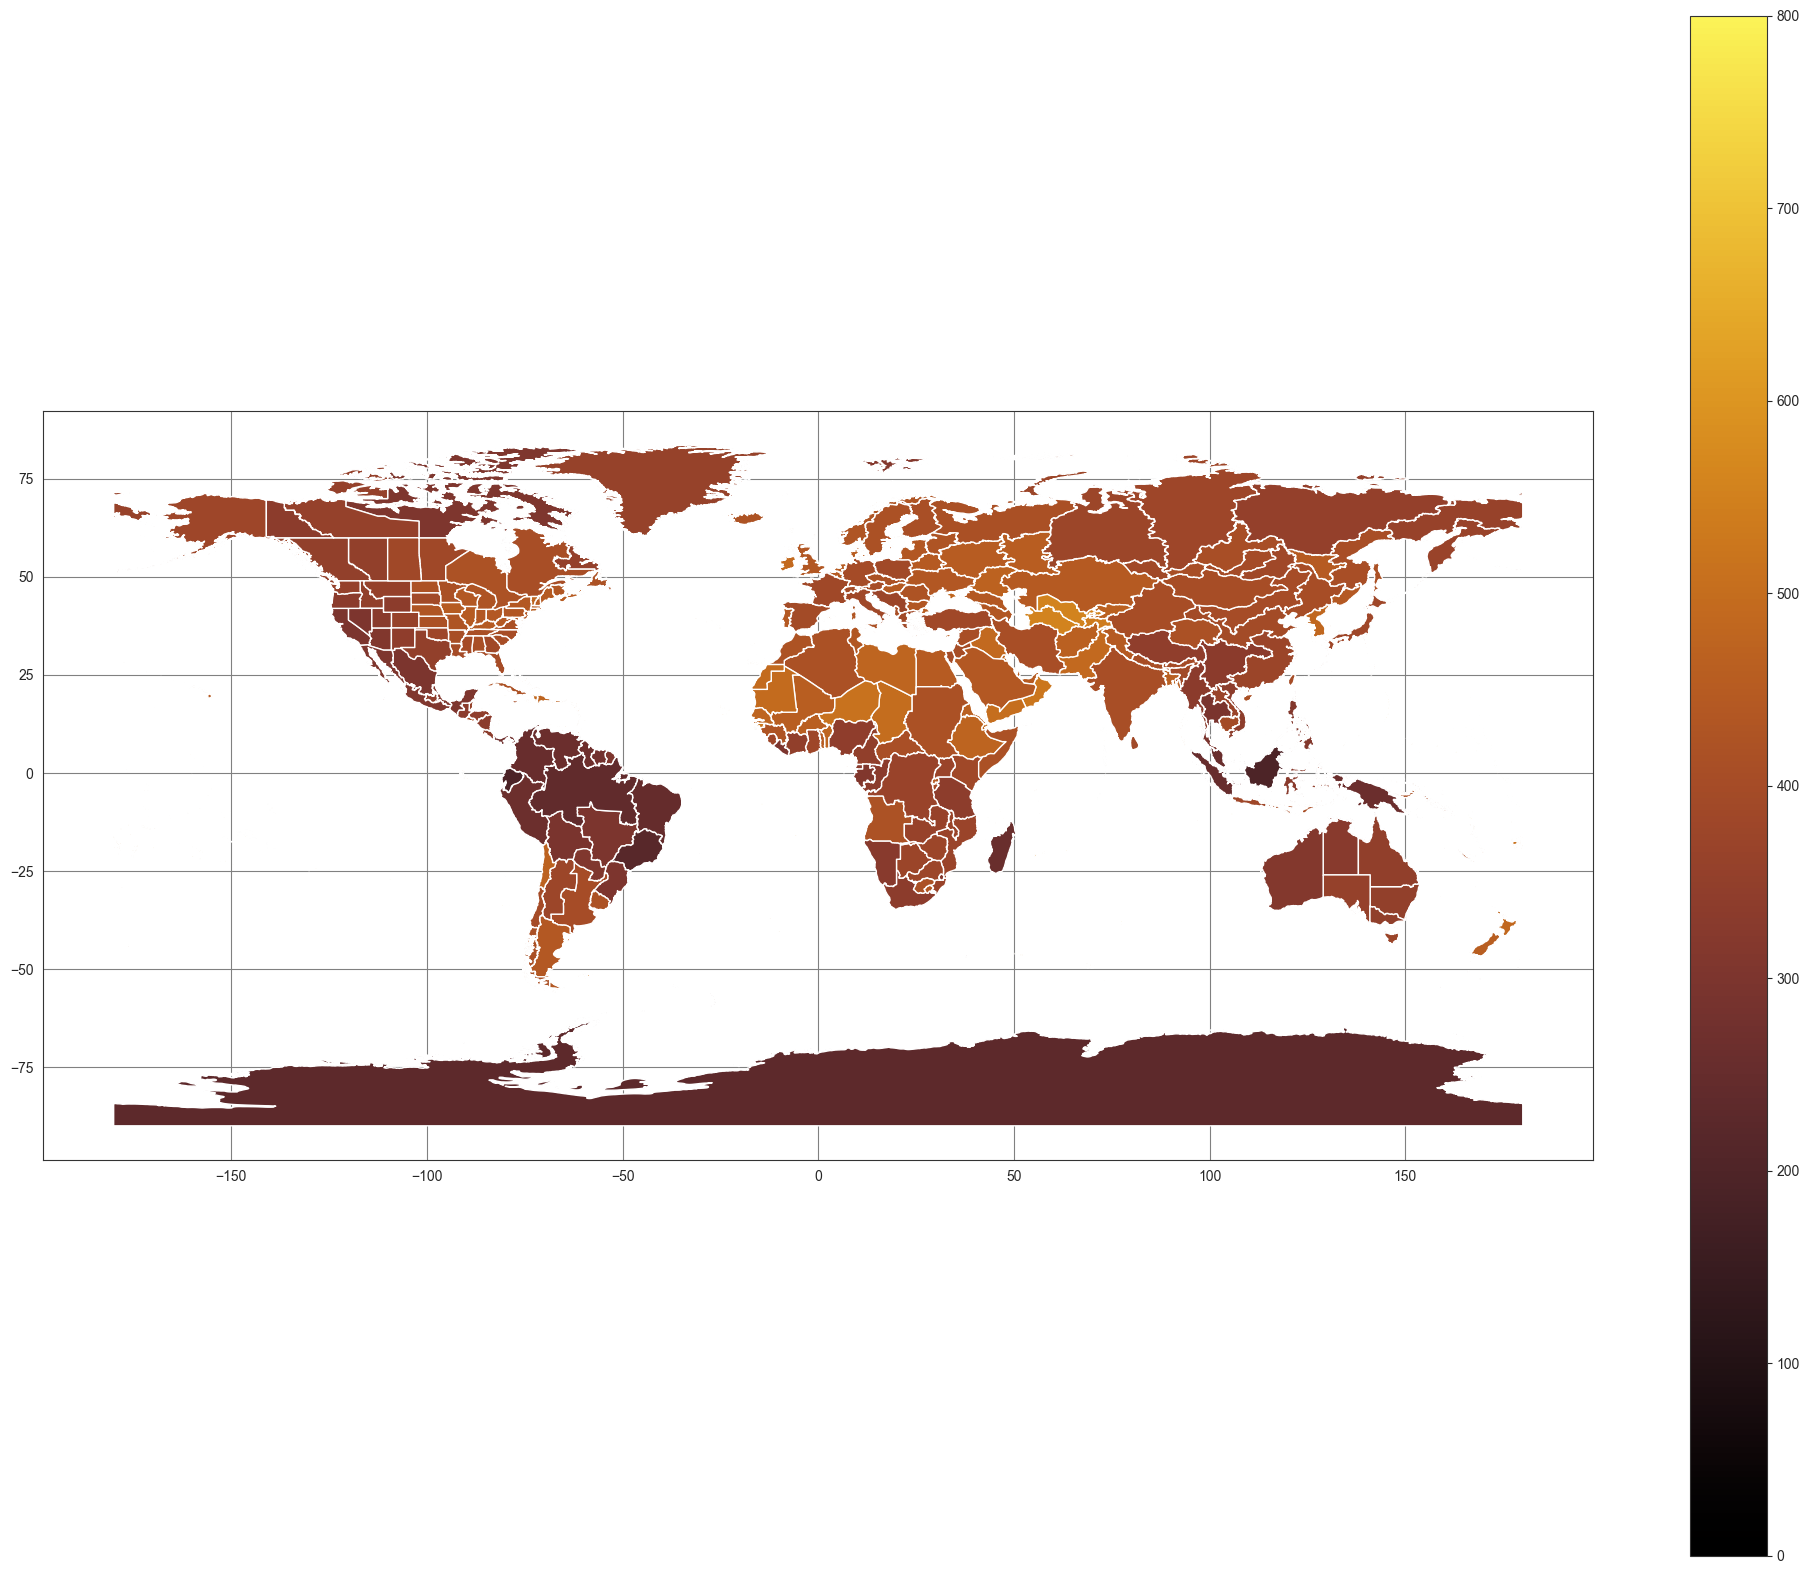

In [92]:
df_WIKI_GIFT_Geo_Level_3.plot(figsize=(25, 20), column = "description_word_count", 
           legend=True,cmap=cmap, vmin = 0, vmax = 800)